In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-10 21:18:23.296713: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/drive0-storage/Gracia/dataset_3/training"
val_path = "/drive0-storage/Gracia/dataset_3/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-10 21:18:26.563770: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 21:18:27.270267: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 16332 files belonging to 3 classes.
Found 4080 files belonging to 3 classes.


In [ ]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 244.90761
(184, 216, 3)


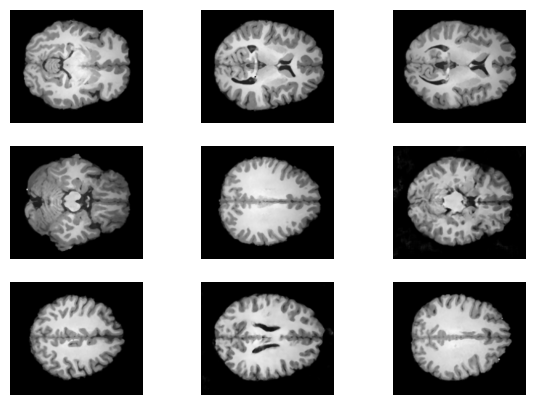

In [5]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [4]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [5]:
print(len(validation_dataset))
print(len(test_dataset))

64
64


## Model building

In [9]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [10]:
with tf.device("GPU"):
    vgg16 = build_vgg16()

    # add rescale layer, chain model
    rescale = tf.keras.layers.Rescaling(1./255)
    inputs = tf.keras.Input(shape = img_shape)
    x = rescale(inputs)
    outputs = vgg16(x)
    model = tf.keras.Model(inputs,outputs) 
    
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [11]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn3_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [13]:
EPOCH = 25

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/25
511/511 [==============================] - 86s 166ms/step - loss: 1.0832 - accuracy: 0.3931 - val_loss: 1.0994 - val_accuracy: 0.3474
Epoch 2/25
511/511 [==============================] - 84s 164ms/step - loss: 0.9184 - accuracy: 0.5322 - val_loss: 1.0879 - val_accuracy: 0.4149
Epoch 3/25
511/511 [==============================] - 84s 164ms/step - loss: 0.8430 - accuracy: 0.5793 - val_loss: 1.0994 - val_accuracy: 0.4040
Epoch 4/25
511/511 [==============================] - 84s 164ms/step - loss: 0.7946 - accuracy: 0.6157 - val_loss: 1.0318 - val_accuracy: 0.4424
Epoch 5/25
511/511 [==============================] - 84s 164ms/step - loss: 0.7589 - accuracy: 0.6344 - val_loss: 0.9962 - val_accuracy: 0.4966
Epoch 6/25
511/511 [==============================] - 84s 164ms/step - loss: 0.7207 - accuracy: 0.6583 - val_loss: 0.9464 - val_accuracy: 0.5148
Epoch 7/25
511/511 [==============================] - 84s 164ms/step - loss: 0.6937 - accuracy: 0.6785 - val_loss: 0.8956 - val_ac

In [15]:
model.save('./models/cnn3_25epoch.h5')

### Training evaluation

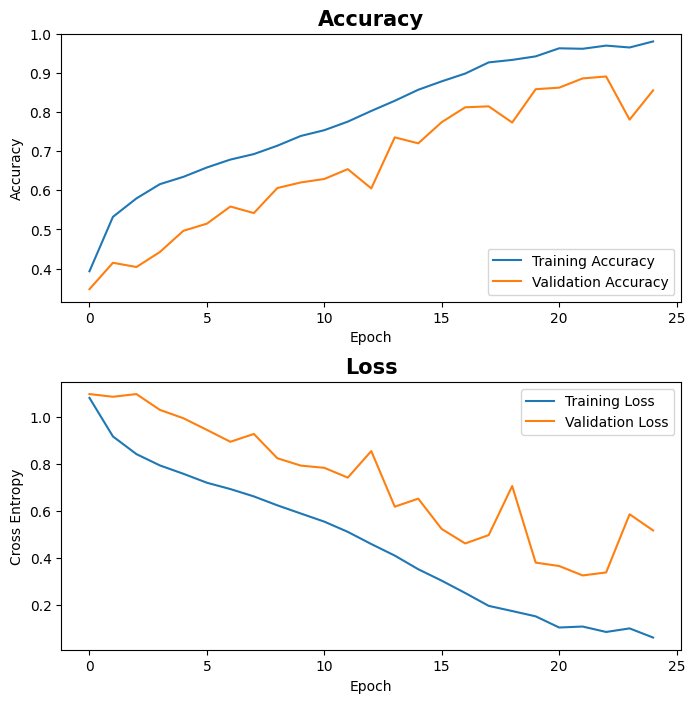

In [14]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

In [20]:
acc

[0.3930933177471161,
 0.5322067141532898,
 0.5792921781539917,
 0.6156625151634216,
 0.6343986988067627,
 0.658278226852417,
 0.6784839630126953,
 0.6925055384635925,
 0.7139358520507812,
 0.7388562560081482,
 0.7535513043403625,
 0.7754102349281311,
 0.8027185797691345,
 0.8286799192428589,
 0.8568454384803772,
 0.878337025642395,
 0.8982365727424622,
 0.9267695546150208,
 0.9331374168395996,
 0.942138135433197,
 0.9627724885940552,
 0.9615479111671448,
 0.9696301817893982,
 0.9648543000221252,
 0.9802840948104858]

In [21]:
val_acc

[0.3474409580230713,
 0.4148622155189514,
 0.40403541922569275,
 0.4424212574958801,
 0.4965551197528839,
 0.5147637724876404,
 0.5585629940032959,
 0.5418307185173035,
 0.6058070659637451,
 0.6200787425041199,
 0.6289370059967041,
 0.6540354490280151,
 0.6048228144645691,
 0.7352362275123596,
 0.7199802994728088,
 0.774114191532135,
 0.8120078444480896,
 0.814468502998352,
 0.773129940032959,
 0.8582677245140076,
 0.8622047305107117,
 0.8858267664909363,
 0.8907480239868164,
 0.7805117964744568,
 0.8553149700164795]

In [22]:
loss

[1.083194375038147,
 0.9183787107467651,
 0.8429656624794006,
 0.7945696115493774,
 0.7589226365089417,
 0.7207263708114624,
 0.6936652064323425,
 0.66225665807724,
 0.6242268681526184,
 0.5891931653022766,
 0.5544854998588562,
 0.510814368724823,
 0.45881691575050354,
 0.4094841778278351,
 0.3511851727962494,
 0.3022988438606262,
 0.24964727461338043,
 0.19471468031406403,
 0.17265070974826813,
 0.1500033140182495,
 0.10228517651557922,
 0.10641569644212723,
 0.08327257633209229,
 0.09848473966121674,
 0.05940942093729973]

In [23]:
val_loss

[1.0994123220443726,
 1.087929129600525,
 1.0993645191192627,
 1.031792402267456,
 0.9962171316146851,
 0.9464344382286072,
 0.89558345079422,
 0.9290677905082703,
 0.8253048658370972,
 0.7938435077667236,
 0.7844094038009644,
 0.7424740791320801,
 0.8559830784797668,
 0.6184482574462891,
 0.6526331305503845,
 0.5229756236076355,
 0.46132931113243103,
 0.4970508813858032,
 0.7065311670303345,
 0.3794771134853363,
 0.36495593190193176,
 0.32463183999061584,
 0.3374950885772705,
 0.5860341191291809,
 0.5168794393539429]

## Testing

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [17]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

64/64 [==============================] - 4s 57ms/step - loss: 0.5079 - accuracy: 0.8623


{'loss': 0.5078572034835815, 'accuracy': 0.8623046875}

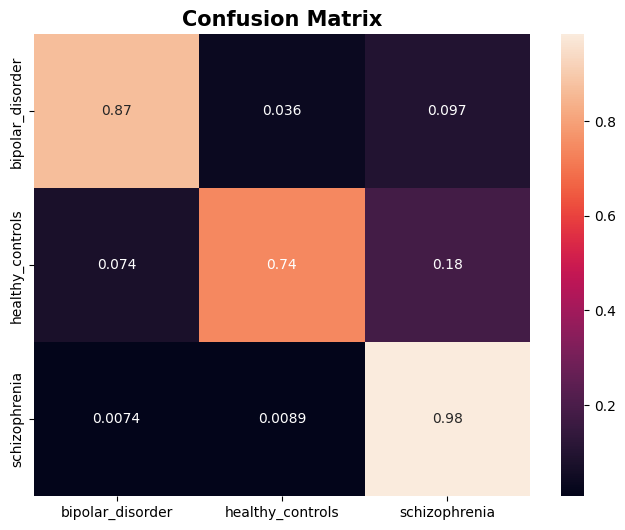

In [18]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN3_cm.png')
plt.show()

In [19]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.8623046875
Precision: 0.8788414049664195
Sensitivity: 0.86474609375
Specificity: 0.9323531154883309
